In [173]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from scipy.optimize import least_squares
from helperClasses.DataPipeline import DataPipeline

In [174]:
df_cam = pd.read_csv("../Dataframe/df_detected_objects_game.csv")
df_labels = pd.read_csv("../Dataframe/tennis_labels.csv", sep=";")
#Spalten ohne Werte entfernen
df_cam = df_cam.drop(columns= ["head_x", "head_y", "head_z"], axis=1)

In [175]:
df_cam["object_id"] = df_cam["object_id"].astype("category")
df_cam["object_label"] = df_cam["object_label"].astype("category")
df_cam["tracking_state"] = df_cam["tracking_state"].astype("category")

In [176]:
df_cam.shape

(42571, 14)

## Hilfe Funktionen

Um neue Spalten zu erstellen oder die Koordiante der Kamera auf das Tennisfeld zu projizieren, brauchen wir eine Funktion, die uns die Koordinaten der Kamera auf das Tennisfeld projiziert.

In [177]:
def tennisfeld(r, P1, P2, P3):
    r1 = P2 - P1
    r3 = P3 - 0.5*(P1 + P2)
    # Basisvektoren
    r1u = r1 / np.sqrt(np.dot(r1, r1))
    r3u = r3 / np.sqrt(np.dot(r3, r3))
    r2u = np.cross(r1u, r3u)
    # Translation
    T0 = P3
    # Rotation
    M1 = np.c_[r1u, r2u, r3u]
    M1_inv = np.linalg.inv(M1)
    # Abbildung
    return np.inner(M1_inv, (r - T0))


In [178]:
def drawTennisField():
    plt.plot([4.11, 4.11], [-11.89, 11.89], 'k', lw=2) # Single sideline rechts
    plt.plot([5.48, 5.48], [-11.89, 11.89], 'k', lw=2) # Double sideline rechts
    plt.plot([-4.11, -4.11], [-11.89, 11.89], 'k', lw=2) # Single sideline links
    plt.plot([-5.48, -5.48], [-11.89, 11.89], 'k', lw=2) # Double sideline links
    plt.plot([0, 0], [-6.40, 6.40], 'k', lw=2) # Center Service Line
    plt.plot([-5.48, 5.48], [0, 0], 'k', lw=2) # Net
    plt.plot([-5.48, 5.48], [11.89, 11.89], 'k', lw=2) # Baseline oben
    plt.plot([-5.48, 5.48], [-11.89, -11.89], 'k', lw=2) # Baseline unten
    plt.plot([-4.11, 4.11], [-6.40, -6.40], 'k', lw=2) # Service Line unten
    plt.plot([-4.11, 4.11], [6.40, 6.40], 'k', lw=2) # Service Line oben

In [179]:
def zonen(y):
    abs_y = abs(y)
    if 6.4 > abs_y:  # Vom Netz bis zur Aufschlaglinie
        return "Sehr Offensiv"
    elif 11 > abs_y:  #Bis fast zur Grundlinie
        return "Offensiv"
    elif 12.1 > abs_y:  # Etwas hinter der Grundlinie
        return "Neutral"
    else:  # Deutlich hinter der Grundlinie
        return "Defensiv"


In [180]:
def position(x):
    def_grenze = 1.5
    if x > def_grenze:
        return "Rechts"
    elif x < -def_grenze:
        return "Links"
    else:
        return "Mitte"


# Datawrangling

## Kamera Dataframe

### Koordinaten der Kamera auf das Tennisfeld projizieren

In [181]:
# Kooridnaten auf dem Tennisfeld als Kalibrierung
P1=np.array([-4.207, -1.846, 5.733]) # Linke Ecke an der Grundlinie
P2=np.array([3.415, -1.870, 5.489]) # Rechte Ecke an der Grundlinie
P3=np.array([-0.057, -1.703, 15.554])   # Mittelpunkt am Netz

In [182]:
df_cam["z"] = df_cam["z"].apply(abs)

Weil die Kamera die Z-Achse negativ ausgibt und die Basistransformation nur positive Werte erwartet, drehen wir die Z-Achse um.

In [183]:
df_cam[['new_x', 'new_y', 'new_z']] = df_cam.apply(lambda row: pd.Series(tennisfeld(np.array([row['x'], row['y'], row['z']]), P1, P2, P3)), axis=1)
df_cam.drop(columns=["x", "y", "z"], inplace=True)

### Visualisierung auf dem Tennisfeld

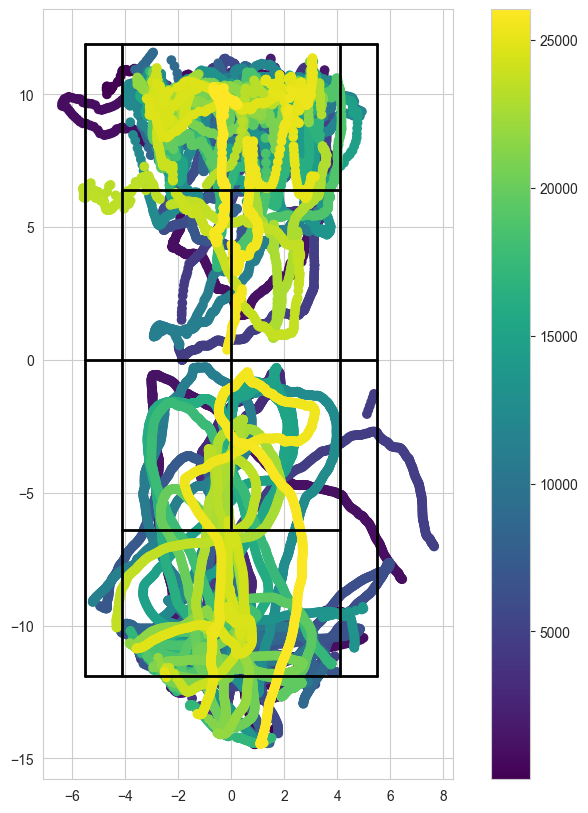

In [184]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x=df_cam['new_x'], y=df_cam['new_z'], c=df_cam['frame'], cmap='viridis')
drawTennisField()
plt.colorbar()
ax.set_aspect('equal')
plt.show()

Wir sehen, dass die Kamera den ersten Spieler sehr gut erkennt, aber der zweite Spieler scheint etwas zu weit vorne zu stehen. 
Wir geben dem zweiten Spieler einen Offset von 2m nach hinten.

Um den Daten aber einen Offset zu geben, beheben wir noch ein anderes Problem. Die Objekte haben viele verschiedene IDs, wir werden diese anhand der Koordianten anpassen.

In [185]:
df_cam["object_id"] = np.where(df_cam["new_z"] < 0, "Player1", "Player2")

### Offset

In [186]:
df_cam.loc[df_cam["object_id"] == "Player2", "new_z"] = df_cam.loc[df_cam["object_id"] == "Player2", "new_z"] + 2

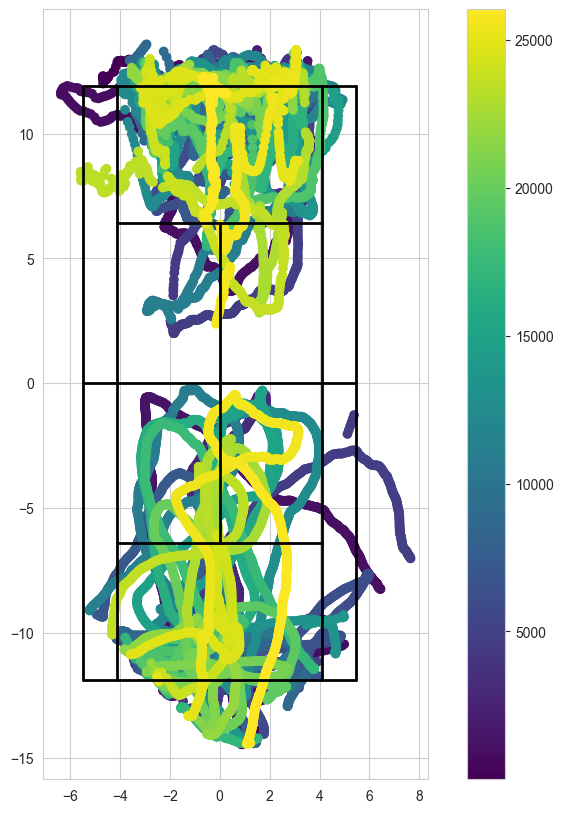

In [187]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x=df_cam['new_x'], y=df_cam['new_z'], c=df_cam['frame'], cmap='viridis')
drawTennisField()
plt.colorbar()
ax.set_aspect('equal')
plt.show()

Das Ergebnis sieht nun besser aus, obwohl die bewegung des zweiten Spielers etwas komisch aussieht.
Das liegt wahrscheinlich daran, dass die Kamera auf weitere Entfernung nicht mehr so genau ist.

### Doppelte Frames

Die Kamera gibt die Position für beide Spieler in einer seperaten Zeile aus. Da sie aber im geleichen Frame aufgenommen wurden, können wir diese zusammenführen.

Um Fehler auszuschliessen schneiden wir die Daten anhand der Labels, da wir Start und Endzeitpunkt kennen.

In [188]:
max_label = df_labels["Frame"].max()
min_label = df_labels["Frame"].min()

In [189]:
df_cam = df_cam[(df_cam["frame"] >= min_label) & (df_cam["frame"] <= max_label)]

In [190]:
df_cam[df_cam.isna().any(axis=1)]

,frame,object_id,object_label,confidence,tracking_state,vx,xy,vz,width,height,length,new_x,new_y,new_z
22210,13586,Player2,Person,82.42188,OK,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
22212,13587,Player2,Person,87.59766,OK,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
22214,13588,Player2,Person,87.59766,OK,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
22216,13589,Player2,Person,89.59961,OK,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
22218,13590,Player2,Person,89.50195,OK,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
22220,13591,Player2,Person,90.38086,OK,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN


Die Daten lassens sich aber nicht einfach zum andere Format umwandeln. Das Problem liegt an den vergebenen IDs. Die Kamera vergibt immer neue IDs, wenn ein Objekt nicht mehr erkannt wird. Wir umgehen dass, in dem wir sagen positive z-Koordiante rist Player 2 und negative Player 1. Da die Kamera aber etwas ungenau ist am Netz vorne müssen wir die Daten anpassen.

In [191]:
len(df_cam[df_cam.duplicated(subset=["frame", "object_id"], keep=False)])

68

Glücklicherweise kommt es nur 68 mal vor also entfernen wir diese Frames

In [192]:
df_cam = df_cam.drop_duplicates(subset=["frame", "object_id"], keep=False)

In [193]:
df_cam

,frame,object_id,object_label,confidence,tracking_state,vx,xy,vz,width,height,length,new_x,new_y,new_z
521,287,Player1,Person,83.69141,OK,0.01540,-0.04420,0.15406,0.64888,1.99435,0.64888,0.488342,-1.157367,-9.915421
522,287,Player2,Person,32.34863,OK,-0.06328,0.04720,-0.17333,0.61570,1.17692,0.61570,-2.556822,5.167203,11.479640
523,288,Player1,Person,87.69531,OK,0.02580,-0.03045,0.10899,0.66799,1.97376,0.66799,0.487970,-1.155410,-9.916995
524,288,Player2,Person,33.88672,OK,-0.05046,0.03763,-0.13822,0.61899,1.17656,0.61899,-2.551163,5.141961,11.366557
525,289,Player1,Person,87.45117,OK,0.02339,-0.02760,0.09879,0.68904,1.95456,0.68904,0.487290,-1.155982,-9.917908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41443,25418,Player2,Person,53.32031,OK,0.35546,-0.14441,0.56125,0.61038,1.38896,0.61039,0.834903,4.535234,10.239158
41444,25419,Player1,Person,75.58594,OK,1.42219,-0.00269,0.27825,0.71328,1.65808,0.71328,1.689395,0.776300,-2.944103
41445,25419,Player2,Person,54.58984,OK,0.26817,-0.08407,0.33846,0.60976,1.39458,0.60976,0.832179,4.524261,10.182033
41446,25420,Player1,Person,74.56055,OK,1.36259,0.00797,0.23094,0.68662,1.65815,0.68662,1.714517,0.774839,-2.944206


### Duplikate

Vorhin haben wir schon nach Duplikate gesucht, aber nur nach Frames und IDs. Wir betrachten nun die Koordinaten.

In [194]:
df_cam[df_cam.duplicated()]

,frame,object_id,object_label,confidence,tracking_state,vx,xy,vz,width,height,length,new_x,new_y,new_z


Glücklicherweise gibt es keine Duplikate.

## NaN Werte

In [195]:
df_cam[df_cam.isna().any(axis=1)]

,frame,object_id,object_label,confidence,tracking_state,vx,xy,vz,width,height,length,new_x,new_y,new_z


In [196]:
df_cam_wrangled = df_cam.dropna()

Die Spalten müssen leider entfernen werden auch wenn sehr viele sind.

## Label Dataframe

In [197]:
df_labels.head()

,Frame,Status,Schlag Spieler 1,Schlag Spieler 2,Satz
0,287,Aktiv,Anschlag,NaN,1.0
1,318,NaN,NaN,Fronthand,NaN
2,372,NaN,Fronthand,NaN,NaN
3,421,NaN,NaN,Backhand,NaN
4,469,NaN,Backhand,NaN,NaN


Da das gelabelte Dataframe erzeugt wurde, gehen wir von keinen Fehlern aus

## Merge der beiden Dataframes

In [198]:
df_cam_pivot = pd.pivot(df_cam_wrangled, index="frame", columns="object_id", values=["new_x", "new_y", "new_z", 'vx', 'xy', 'vz', 'width', 'height', 'length'])
#Collapse the MultiIndex
df_cam_pivot.columns = df_cam_pivot.columns.map('_'.join).str.strip()
#Reset Index to get the Name column back
df_cam_pivot = df_cam_pivot.reset_index()

In [199]:
df_cam_pivot.head()

,frame,new_x_Player1,new_x_Player2,new_y_Player1,new_y_Player2,new_z_Player1,new_z_Player2,vx_Player1,vx_Player2,xy_Player1,xy_Player2,vz_Player1,vz_Player2,width_Player1,width_Player2,height_Player1,height_Player2,length_Player1,length_Player2
0,287,0.488342,-2.556822,-1.157367,5.167203,-9.915421,11.479640,0.01540,-0.06328,-0.04420,0.04720,0.15406,-0.17333,0.64888,0.61570,1.99435,1.17692,0.64888,0.61570
1,288,0.487970,-2.551163,-1.155410,5.141961,-9.916995,11.366557,0.02580,-0.05046,-0.03045,0.03763,0.10899,-0.13822,0.66799,0.61899,1.97376,1.17656,0.66799,0.61899
2,289,0.487290,-2.544400,-1.155982,5.116309,-9.917908,11.280055,0.02339,-0.06145,-0.02760,0.04583,0.09879,-0.16830,0.68904,0.62047,1.95456,1.17893,0.68904,0.62047
3,290,0.482031,-2.544177,-1.156393,5.107507,-9.918351,11.270463,0.02728,-0.04928,-0.03218,0.03674,0.11523,-0.13497,0.71109,0.62504,1.95276,1.18399,0.71109,0.62504
4,291,0.477606,-2.544681,-1.157121,5.102722,-9.919782,11.268751,0.01641,-0.04386,-0.01936,0.03270,0.06932,-0.12013,0.73265,0.62681,1.94945,1.17943,0.73265,0.62681


In [200]:
df = pd.merge(df_cam_pivot, df_labels, left_on="frame", right_on="Frame", how="left")
df = df.drop(columns=["Frame"])

In [201]:
df[["Status", "Satz"]] = df[["Status", "Satz"]].ffill()

In [202]:
df = df.loc[df["Status"] != "Inaktiv"]

In [203]:
df["geschwindigkeit_p1"] = np.sqrt(df["vx_Player1"] ** 2 + df["xy_Player1"] ** 2 + df["vz_Player1"] ** 2)
df["geschwindigkeit_p2"] = np.sqrt(df["vx_Player2"] ** 2 + df["xy_Player2"] ** 2 + df["vz_Player2"] ** 2)

C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


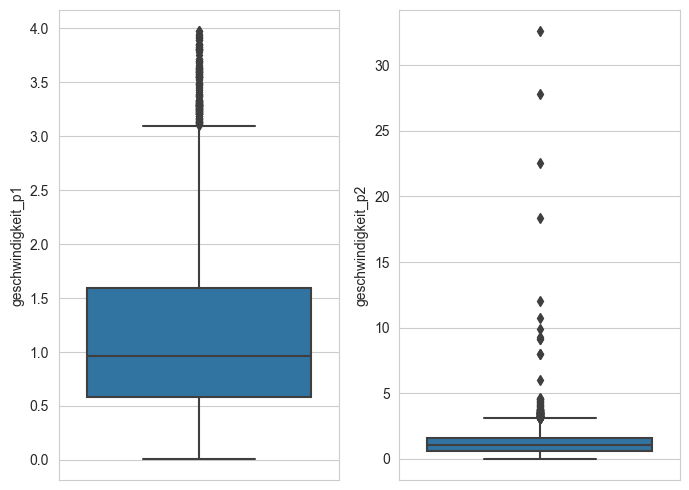

In [204]:
plt.figure(figsize=(7, 5))

plt.subplot(121)
sns.boxplot(y=df["geschwindigkeit_p1"])

plt.subplot(122)
sns.boxplot(y=df["geschwindigkeit_p2"])
plt.tight_layout()
plt.show()

In [205]:
df["geschwindigkeit_p1"] = df["geschwindigkeit_p1"].rolling(10, min_periods=1).median()
df["geschwindigkeit_p2"] = df["geschwindigkeit_p2"].rolling(10, min_periods=1).median()

C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


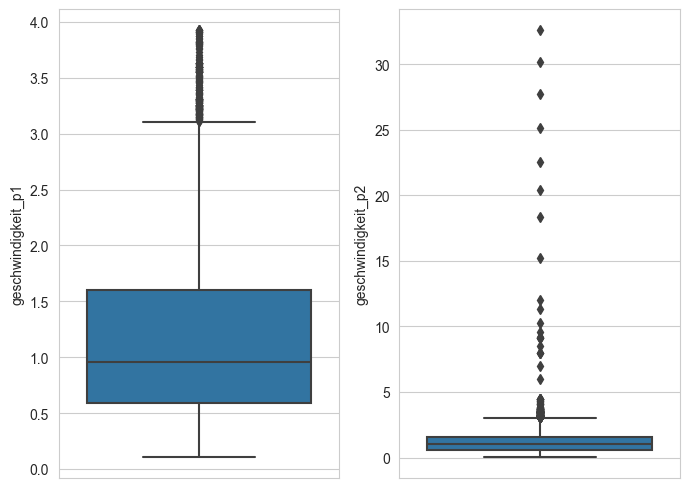

In [206]:
plt.figure(figsize=(7, 5))

plt.subplot(121)
sns.boxplot(y=df["geschwindigkeit_p1"])

plt.subplot(122)
sns.boxplot(y=df["geschwindigkeit_p2"])
plt.tight_layout()
plt.show()

Immer komische Werte bei der Geschwindigkeit

In [207]:
wrong_vel = df.loc[(df["geschwindigkeit_p2"] > 5) ][["new_x_Player2", "new_y_Player2", "new_z_Player2", "geschwindigkeit_p2","geschwindigkeit_p1"]]

In [208]:
vect = wrong_vel[-1:].values - wrong_vel[:1].values
df["geschwindigkeit_p2"].values[(df["geschwindigkeit_p2"].values > 5) ] = np.sqrt(vect[:,0] ** 2 + vect[:,1] ** 2 + vect[:,2] ** 2)

C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


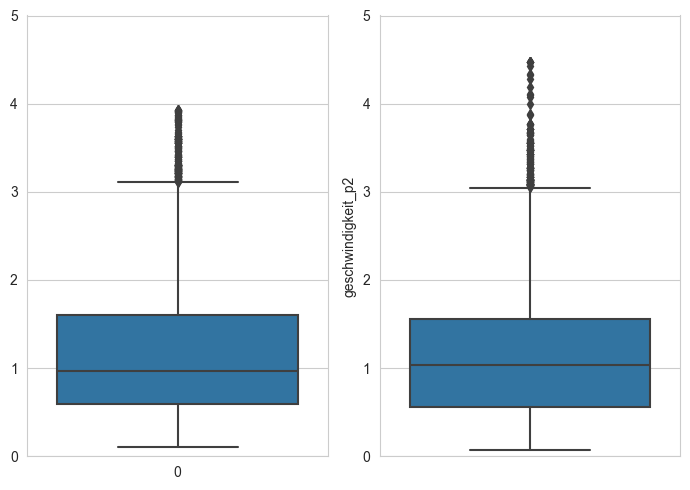

In [209]:
plt.figure(figsize=(7, 5))

plt.subplot(121)
sns.boxplot(df["geschwindigkeit_p1"])
plt.ylim(0, 5)

plt.subplot(122)
sns.boxplot(y=df["geschwindigkeit_p2"])
plt.ylim(0, 5)
plt.tight_layout()
plt.show()

In [210]:
#
df["zone_p1"] = df["new_z_Player1"].apply(zonen)
df["zone_p2"] = df["new_z_Player2"].apply(zonen)
#
df["pos_p1"] = df["new_x_Player1"].apply(position)
df["pos_p2"] = df["new_x_Player2"].apply(position)

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5538 entries, 0 to 23973
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   frame               5538 non-null   int64  
 1   new_x_Player1       5449 non-null   float64
 2   new_x_Player2       4787 non-null   float64
 3   new_y_Player1       5449 non-null   float64
 4   new_y_Player2       4787 non-null   float64
 5   new_z_Player1       5449 non-null   float64
 6   new_z_Player2       4787 non-null   float64
 7   vx_Player1          5449 non-null   float64
 8   vx_Player2          4787 non-null   float64
 9   xy_Player1          5449 non-null   float64
 10  xy_Player2          4787 non-null   float64
 11  vz_Player1          5449 non-null   float64
 12  vz_Player2          4787 non-null   float64
 13  width_Player1       5449 non-null   float64
 14  width_Player2       4787 non-null   float64
 15  height_Player1      5449 non-null   float64
 16  height_Pla

In [212]:
df.drop(columns=['vx_Player1', 'vx_Player2', 'xy_Player1', 'xy_Player2', 'vz_Player1', 'vz_Player2'], inplace=True)

In [213]:
df["Status"] = df["Status"].astype("category")
df["Schlag Spieler 1"] = df["Schlag Spieler 1"].astype("category")
df["Schlag Spieler 2"] = df["Schlag Spieler 2"].astype("category")
df["Satz"] = df["Satz"].astype("category")
df["zone_p1"] = df["zone_p1"].astype("category")
df["zone_p2"] = df["zone_p2"].astype("category")
df["pos_p1"] = df["pos_p1"].astype("category")
df["pos_p2"] = df["pos_p2"].astype("category")

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5538 entries, 0 to 23973
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   frame               5538 non-null   int64   
 1   new_x_Player1       5449 non-null   float64 
 2   new_x_Player2       4787 non-null   float64 
 3   new_y_Player1       5449 non-null   float64 
 4   new_y_Player2       4787 non-null   float64 
 5   new_z_Player1       5449 non-null   float64 
 6   new_z_Player2       4787 non-null   float64 
 7   width_Player1       5449 non-null   float64 
 8   width_Player2       4787 non-null   float64 
 9   height_Player1      5449 non-null   float64 
 10  height_Player2      4787 non-null   float64 
 11  length_Player1      5449 non-null   float64 
 12  length_Player2      4787 non-null   float64 
 13  Status              5538 non-null   category
 14  Schlag Spieler 1    75 non-null     category
 15  Schlag Spieler 2    62 non-null     catego

## Explorative Datenanalyse

In [215]:
df.shape

(5538, 23)

In [216]:
df.head(100)

,frame,new_x_Player1,new_x_Player2,new_y_Player1,new_y_Player2,new_z_Player1,new_z_Player2,width_Player1,width_Player2,height_Player1,...,Status,Schlag Spieler 1,Schlag Spieler 2,Satz,geschwindigkeit_p1,geschwindigkeit_p2,zone_p1,zone_p2,pos_p1,pos_p2
0,287,0.488342,-2.556822,-1.157367,5.167203,-9.915421,11.479640,0.64888,0.61570,1.99435,...,Aktiv,Anschlag,NaN,1.0,0.161013,0.190461,Offensiv,Neutral,Mitte,Links
1,288,0.487970,-2.551163,-1.155410,5.141961,-9.916995,11.366557,0.66799,0.61899,1.97376,...,Aktiv,NaN,NaN,1.0,0.138540,0.171170,Offensiv,Neutral,Mitte,Links
2,289,0.487290,-2.544400,-1.155982,5.116309,-9.917908,11.280055,0.68904,0.62047,1.95456,...,Aktiv,NaN,NaN,1.0,0.116067,0.184936,Offensiv,Neutral,Mitte,Links
3,290,0.482031,-2.544177,-1.156393,5.107507,-9.918351,11.270463,0.71109,0.62504,1.95276,...,Aktiv,NaN,NaN,1.0,0.119389,0.168407,Offensiv,Neutral,Mitte,Links
4,291,0.477606,-2.544681,-1.157121,5.102722,-9.919782,11.268751,0.73265,0.62681,1.94945,...,Aktiv,NaN,NaN,1.0,0.116067,0.151878,Offensiv,Neutral,Mitte,Links
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,382,2.759237,0.226410,-1.838264,5.150879,-11.095435,12.121358,0.68311,0.75847,1.76520,...,Aktiv,NaN,NaN,1.0,1.069860,0.423503,Neutral,Defensiv,Rechts,Mitte
96,383,2.755462,0.212789,-1.835199,5.158845,-11.083066,12.172864,0.67856,0.76611,1.76421,...,Aktiv,NaN,NaN,1.0,0.993672,0.391667,Neutral,Defensiv,Rechts,Mitte
97,384,2.751136,0.205017,-1.833197,5.161716,-11.074870,12.191233,0.68254,0.77897,1.76047,...,Aktiv,NaN,NaN,1.0,0.919465,0.361876,Neutral,Defensiv,Rechts,Mitte
98,385,2.747896,0.199952,-1.831858,5.162492,-11.069841,12.193130,0.69038,0.78717,1.75721,...,Aktiv,NaN,NaN,1.0,0.847901,0.332086,Neutral,Defensiv,Rechts,Mitte


In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5538 entries, 0 to 23973
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   frame               5538 non-null   int64   
 1   new_x_Player1       5449 non-null   float64 
 2   new_x_Player2       4787 non-null   float64 
 3   new_y_Player1       5449 non-null   float64 
 4   new_y_Player2       4787 non-null   float64 
 5   new_z_Player1       5449 non-null   float64 
 6   new_z_Player2       4787 non-null   float64 
 7   width_Player1       5449 non-null   float64 
 8   width_Player2       4787 non-null   float64 
 9   height_Player1      5449 non-null   float64 
 10  height_Player2      4787 non-null   float64 
 11  length_Player1      5449 non-null   float64 
 12  length_Player2      4787 non-null   float64 
 13  Status              5538 non-null   category
 14  Schlag Spieler 1    75 non-null     category
 15  Schlag Spieler 2    62 non-null     catego

In [218]:
df.describe(include="all")

,frame,new_x_Player1,new_x_Player2,new_y_Player1,new_y_Player2,new_z_Player1,new_z_Player2,width_Player1,width_Player2,height_Player1,...,Status,Schlag Spieler 1,Schlag Spieler 2,Satz,geschwindigkeit_p1,geschwindigkeit_p2,zone_p1,zone_p2,pos_p1,pos_p2
count,5538.000000,5449.000000,4787.000000,5449.000000,4787.000000,5449.000000,4787.000000,5449.000000,4787.000000,5449.000000,...,5538,75,62,5538.0,5485.000000,5284.000000,5538,5538,5538,5538
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,3,3,3.0,NaN,NaN,4,4,3,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Aktiv,Anschlag,Fronthand,3.0,NaN,NaN,Offensiv,Defensiv,Mitte,Mitte
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5538,28,31,2987.0,NaN,NaN,3282,2217,3734,3055
mean,11106.260563,-0.400948,0.684688,-1.312534,4.773249,-10.116067,11.067450,0.825033,0.713452,1.756707,...,NaN,NaN,NaN,NaN,1.172720,1.168838,NaN,NaN,NaN,NaN
std,7612.009150,1.547804,1.874862,0.576069,0.554516,1.769867,1.721171,0.177810,0.085318,0.079917,...,NaN,NaN,NaN,NaN,0.769631,0.758768,NaN,NaN,NaN,NaN
min,287.000000,-4.152590,-6.365507,-2.564604,2.083407,-12.531677,2.003769,0.503380,0.503640,1.114770,...,NaN,NaN,NaN,NaN,0.110637,0.071474,NaN,NaN,NaN,NaN
25%,3905.250000,-1.378311,-0.349279,-1.711116,4.583699,-11.308802,10.526656,0.702420,0.658070,1.715220,...,NaN,NaN,NaN,NaN,0.590300,0.563907,NaN,NaN,NaN,NaN
50%,10420.500000,-0.477857,0.955436,-1.386131,4.960105,-10.444174,11.655178,0.792780,0.706660,1.762010,...,NaN,NaN,NaN,NaN,0.962088,1.036514,NaN,NaN,NaN,NaN
75%,18442.750000,0.375747,2.088762,-1.099705,5.131891,-9.626821,12.186909,0.903750,0.759730,1.798080,...,NaN,NaN,NaN,NaN,1.599577,1.558026,NaN,NaN,NaN,NaN


Wir machen eine kurze Analyse mit describe, um zu sehen ob es auffällige Werte gibt.
- Wir haben für die Analyse 23975 Frames, wo bei ein paar wegfallen, weil die Kamera die Objekte nicht erkannt hat.
- Bei den Kooridante fallen geraden keine auffälligen Werte auf.
- Bei den heights sieht man das Spieler 1 grösser ist als Spieler 2.
- Das der Status mehrheitlich inaktiv ist, ist auch logisch da unterbrüche teilweise etwas länger dauern. Wie lassen dennoch die inactiven Frames im Spiel, um vileicht ein Muster zu erkennen ob der Spieler inaktiv ist.
- Was bei der Aufnahme auch auffgefallen ist, dass der Spieler 1 viel das Spiel startet. 
- Bei den Geschwindigkeiten scheint es ein paar Ausreisser zu geben, die noch untersucht werden müssen.

## Vergleich der Geschwindigkeiten der Spieler

C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


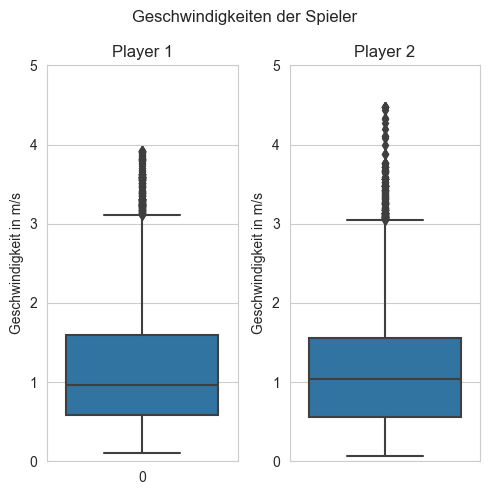

In [220]:
plt.figure(figsize=(5, 5))
plt.suptitle("Geschwindigkeiten der Spieler", fontsize=12)

plt.subplot(121)
sns.boxplot(df["geschwindigkeit_p1"])
plt.ylabel("Geschwindigkeit in m/s")
plt.ylim(0, 5)
plt.title("Player 1")

plt.subplot(122)
sns.boxplot(y=df["geschwindigkeit_p2"])
plt.ylabel("Geschwindigkeit in m/s")
plt.ylim(0, 5)
plt.title("Player 2")
plt.tight_layout()
plt.show()

## Position auf dem Feld

C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\wartm\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


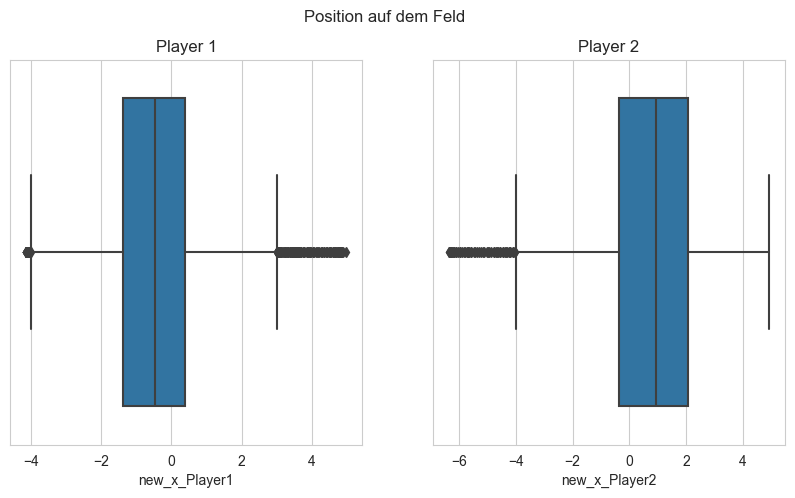

In [221]:
plt.figure(figsize=(10, 5))
plt.suptitle("Position auf dem Feld", fontsize=12)
plt.subplot(121)
plt.title("Player 1")
sns.boxplot(df, x="new_x_Player1")
plt.subplot(122)
plt.title("Player 2")
sns.boxplot(df, x="new_x_Player2")
plt.show()

## Geschwindigkeit über die Zeit

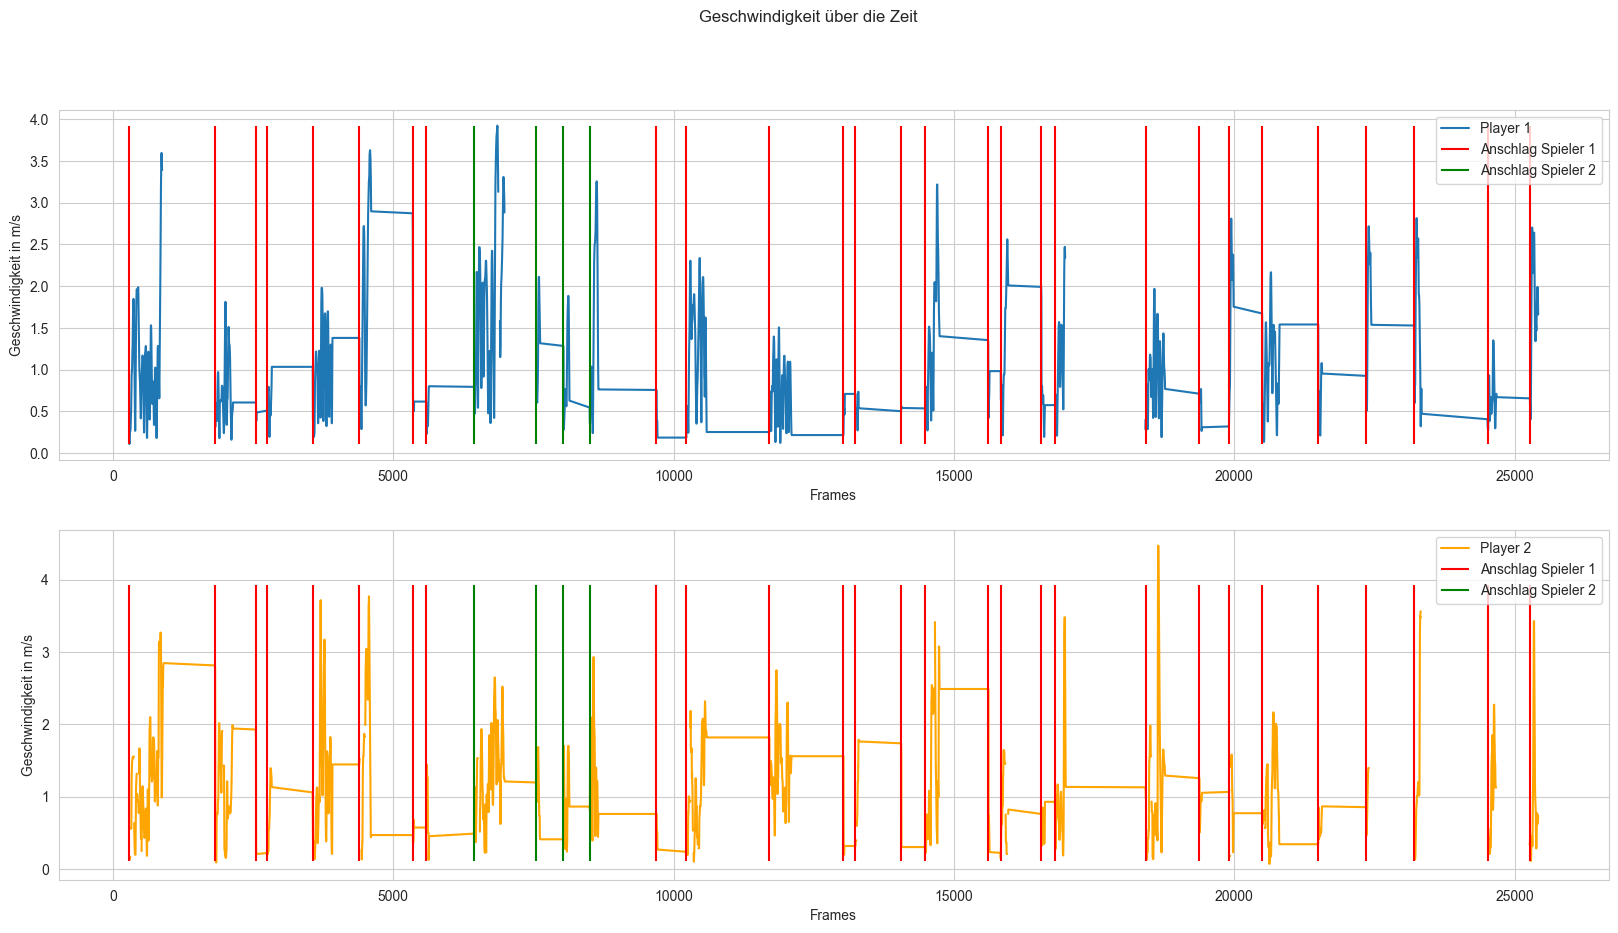

In [243]:
plt.subplots(2,1,figsize=(20, 10))
plt.suptitle("Geschwindigkeit über die Zeit", fontsize=12)
#Subplot für die Geschwindigkeit von Spieler 1
plt.subplot(211)
plt.title("Player 1")
plt.plot(df["frame"], df["geschwindigkeit_p1"], label="Player 1")
plt.xlabel("Frames")
plt.ylabel("Geschwindigkeit in m/s")
plt.vlines(df.loc[df['Schlag Spieler 1'] == "Anschlag"]["frame"], ymin=df["geschwindigkeit_p1"].min(), ymax=df["geschwindigkeit_p1"].max(), color="red", label="Anschlag Spieler 1")
plt.vlines(df.loc[df['Schlag Spieler 2'] == "Anschlag"]["frame"], ymin=df["geschwindigkeit_p1"].min(), ymax=df["geschwindigkeit_p1"].max(), color="green", label="Anschlag Spieler 2")
plt.legend()
#Subplot für die Geschwindigkeit von Spieler 2
plt.subplot(212)
plt.title("Player 2")
plt.plot(df["frame"], df["geschwindigkeit_p2"], label="Player 2", c = "orange")
plt.xlabel("Frames")
plt.ylabel("Geschwindigkeit in m/s")
# Vertikale Linien für die Anschläge von Spieler 1 in rot 
plt.vlines(df.loc[df['Schlag Spieler 1'] == "Anschlag"]["frame"], ymin=df["geschwindigkeit_p1"].min(), ymax=df["geschwindigkeit_p1"].max(), color="red", label="Anschlag Spieler 1")
# Vertikale Linien für die Anschläge von Spieler 1 in grün
plt.vlines(df.loc[df['Schlag Spieler 2'] == "Anschlag"]["frame"], ymin=df["geschwindigkeit_p1"].min(), ymax=df["geschwindigkeit_p1"].max(), color="green", label="Anschlag Spieler 2")
plt.legend()
plt.show()

Deutlich zu sehen ist, das Spieler 1 viel mehr Anschläge macht als Spieler 2. Das ist auch in der Videoaufnahme zu sehen. Wir teilen den Datensatz in drei Teile auf, um zu sehen wie sich die Spieler verhalten.
Die Hypothese ist natürlich das die Spieler müde werden und das Spiel langsamer wird.

### Analyse der drei Sätze

## Position auf dem Feld

## Zone auf dem Feld

P1=np.array([-5.0138, -1.6993, 16.2219])
P2=np.array([4.7026, -1.7650, 15.3967])
P3=np.array([-0.3993, -1.8561, 5.6824]) 

def Tennisfeld(r,P1,P2,P3):
    r1=P2-P1
    r2=-(P3-0.5*(P1+P2))
    # Basisvektoren
    r1u=r1/np.sqrt(np.dot(r1,r1))
    r2u=r2/np.sqrt(np.dot(r2,r2))
    r3u=np.cross(r1u,r2u)
    # Translation
    T0=0.5*(P1+P2)
    # Rotation
    M1=np.c_[r1u,r2u,r3u]
    M1_inv=np.linalg.inv(M1)
    # Abbildung
    return np.inner(M1_inv,(r-T0))  

df_cam = pd.read_csv("../Dataframe/df_detected_objects_game.csv")
df_labels = pd.read_csv("../Dataframe/tennis_labels.csv", sep=";")
#Spalten ohne Werte entfernen
df_cam = df_cam.drop(columns= ["head_x", "head_y", "head_z"], axis=1)

df_cam

df_cam["z"] = df_cam["z"].apply(abs)

def transform_camera_to_field(camera_coords, calibration_points):
    """
    Transform camera coordinates into coordinates on a tennis court.

    :param camera_coords: Array of XYZ coordinates in the camera view.
    :param calibration_points: List of three arrays with the calibration points.
                               Each array contains the camera coordinates and the corresponding field coordinates.
    :return: Transformed coordinates on the tennis court.
    """
    
    # Extract camera and field coordinates from the calibration points
    camera_points = np.array([p[0] for p in calibration_points])
    field_points = np.array([p[1] for p in calibration_points])

    # Define a function for the error between the transformed and actual field points
    def error_func(x, camera_points, field_points):
        r = R.from_rotvec(x[:3])
        t = x[3:]
        transformed_points = r.apply(camera_points) + t
        return (transformed_points - field_points).ravel()

    # Initialize rotation and translation vectors
    x0 = np.zeros(6)

    # Optimize the rotation and translation vectors
    res = least_squares(error_func, x0, args=(camera_points, field_points))

    # Apply the found transformation to the camera coordinates
    r_opt = R.from_rotvec(res.x[:3])
    t_opt = res.x[3:]
    transformed_coords = r_opt.apply(camera_coords) + t_opt

    return transformed_coords

# Camera coordinates provided
P1 = np.array([-5.0138, -1.6993, 16.2219])
P2 = np.array([4.7026, -1.7650, 15.3967])
P3 = np.array([-0.3993, -1.8561, 5.6824]) 

# Calibration points with real-world tennis court coordinates
calibration_points = [
    (P1, np.array([-4.115, 0, 0])),  # left at the net on the sideline
    (P2, np.array([4.115, 0, 0])),   # right at the net on the sideline
    (P3, np.array([0, 0, -11.885]))  # middle of the baseline
]

test_camera_coord = P3  # P1 als Testkoordinate
transformed_test_coord = transform_camera_to_field(test_camera_coord, calibration_points)

def apply_transformation(row):
    camera_coord = np.array([row['x'], row['y'], row['z']])
    transformed_coord = transform_camera_to_field(camera_coord, calibration_points)
    return pd.Series(transformed_coord)

df_cam[['x', 'y', 'z']] = df_cam.apply(apply_transformation, axis=1)

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x=df_cam['x'], y=df_cam['z'], c=df_cam['frame'], cmap='viridis')
drawTennisField()
plt.colorbar()
ax.set_aspect('equal')
plt.show()